In [2]:
# load data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cnn

batch_size = 8

transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = cnn.CustomImageDataset("annotations_file_training.csv", "All_training", 
                                       transform=transforms)

validation_dataset = cnn.CustomImageDataset("annotations_file_validation.csv", "All_validation", 
                                            transform=transforms)

test_dataset = cnn.CustomImageDataset("annotations_file_evaluation.csv", "All_evaluation", 
                                      transform=transforms)
                                            
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': validation_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(validation_dataset)}
                                          
classes = ('bread', 'dairy' 'products', 'dessert', 'eggs', 'fried food', 'meat', 'noodles-pasta', 'rice', 'seafood', 'soup', 'vegetables-fruits')

print('Done')

Done


In [ ]:
# train only linear layer of the model --> transfer learning
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
import cnn
import importlib
importlib.reload(cnn)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
# Initialize model with the best available weights and freeze parameters
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11)
'''
#########
model = resnet50(weights=None)
#########
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized 
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

model = cnn.train_model(model, criterion, optimizer, exp_lr_scheduler, 
                        dataloaders=dataloaders, dataset_sizes=dataset_sizes, num_epochs=45)

print('Finished Training')
PATH = './ResNet50/ResNet50_fully_trained.pth'
torch.save(model, PATH)

In [4]:
# Test the model
model = torch.load('ResNet50/ResNet50_fully_trained.pth').to(device)
try:
    model
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load('ResNet50/ResNet50_trained.pth').to(device)
    print('model loaded')
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(11)]
    n_class_samples = [0 for i in range(11)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images.float())
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(11):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 28.98117717358829 %
Accuracy of bread: 14.130434782608695 %
Accuracy of dairyproducts: 8.783783783783784 %
Accuracy of dessert: 28.6 %
Accuracy of eggs: 23.582089552238806 %
Accuracy of fried food: 8.710801393728223 %
Accuracy of meat: 40.74074074074074 %
Accuracy of noodles-pasta: 1.3605442176870748 %
Accuracy of rice: 1.0416666666666667 %
Accuracy of seafood: 21.122112211221122 %
Accuracy of soup: 53.2 %
Accuracy of vegetables-fruits: 64.5021645021645 %


0


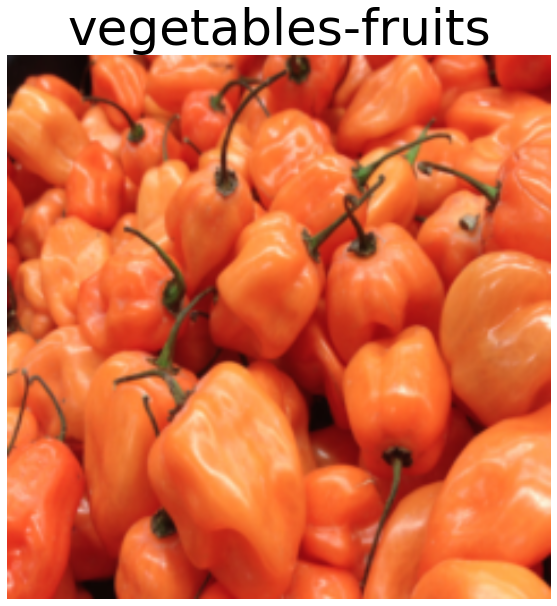

In [65]:
# Display some heatmaps
try:
    model
except NameError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load('ResNet50/ResNet50_trained.pth').to(device)
    print('model loaded')
import cnn
from PIL import Image
import cv2
import importlib
import numpy as np
importlib.reload(cnn)

transform = torchvision.transforms.Resize((512, 512))

# select random sample from test loader
try:
    dataiter
except NameError:    
    dataiter = iter(test_loader)

images, labels = dataiter.next()


# calculate prediction and heatmap
images = images.to(device)
outputs = model(images.float())
_, predicted = torch.max(outputs, 1)

mod = nn.Sequential(*list(model.children())[0:8]) # remove fc layer
feature_convs = mod(images.float())
cams = cnn.returnCAM(feature_convs, model.fc.weight, predicted)

# show original images with heatmaps
images = transform(images).cpu()
images = images * np.array([0.229, 0.224, 0.225])[None, :, None, None] # denormalization
images = images + np.array([0.485, 0.456, 0.406])[None, :, None, None] # denormalization

cnn.show_CAM(cams, images, predicted, classes, 'CAMs/Ref10.png')